# Customer Churn Prediction Using Multiple Classifiers

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [52]:
df1 = pd.read_csv('d1.csv', sep=',', header=0)
df2 = pd.read_csv('d2.csv', sep=',', header=0)

In [53]:
df1['class_x'] = df1['class']
df1 = df1.drop(columns=['class'], axis=1)
df2['class_y'] = df2['class']
df2 = df2.drop(columns=['class'], axis=1)

In [54]:
df = df1.merge(df2)

In [55]:
df = df[df['class_x']==df['class_y']]

In [56]:
for i,j in zip(df['class_x'],df['class_y']):
  if i != j:
    print('not equal values')

In [57]:
df = df.drop(columns=['class_y'], axis=1)
df['class'] = df['class_x']
df = df.drop(columns=['class_x'], axis=1)
df = df.drop(columns=['Unnamed: 0'], axis =1)
df = df[sorted(df.columns)]

In [58]:
random_state = 42
model_labels = ['lp', 'knn', 'dt', 'rf', 'adb']

models = {
    'lp': {
            'name': 'Linear Perceptron',
            'estimator': Perceptron(random_state=random_state),
            'param': {'early_stopping': [True,False], 'class_weight': ['balanced', None]},
          },
    'knn': {
            'name': 'K Nearest Neighbour',
            'estimator': KNeighborsClassifier(),
            'param': {'n_neighbors': [*range(5,11)], 'weights': ['uniform', 'distance']},
          },
    'dt': {
            'name': 'Decision Tree',
            'estimator': DecisionTreeClassifier(random_state=random_state),
            'param': {'criterion': ['gini', 'entropy'], 'max_depth': [*range(5,11)], 'class_weight': ['balanced', None]},
          },
    'rf': {
            'name': 'Random Forest',
            'estimator': RandomForestClassifier(random_state=random_state),
            'param': {'n_estimators': [*range(10,100,20)], 'criterion': ['gini', 'entropy']},
          },
    'adb': {
            'name': 'AdabBoost',
            'estimator': AdaBoostClassifier(random_state=random_state),
            'param': {'n_estimators': [*range(50,100,10)], 'learning_rate': [0.0, 0.5, 1.0]},
          },
}

scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']

clfs = []
results = pd.DataFrame(columns=['scoring', 'model', 'best params',
                        'accuracy', 'f1_macro', 'recall_macro', 'precision_macro'])
skf = StratifiedKFold(n_splits=3, random_state=random_state, shuffle=True)

In [59]:
X = df.drop(columns=['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [60]:
for score in scoring:
  for lbl in model_labels:
    clf = GridSearchCV(models[lbl]['estimator'], models[lbl]['param'], scoring=score, cv=skf, return_train_score=False)
    clf.fit(X_train,y_train)
    y_pre = clf.predict(X_test)
    clfs.append(clf)
    cr = classification_report(y_true=y_test, y_pred=y_pre, labels=clf.classes_, output_dict=True)
    results.loc[len(results)] = [score, models[lbl]['name'], clf.best_params_,
                                 cr['accuracy'],
                                 cr['macro avg']['f1-score'],
                                 cr['macro avg']['recall'],
                                 cr['macro avg']['precision']]


In [ ]:
for score in scoring:
  print("Best parameters for scoring   ***"+score+"***")
  display(results[results['scoring']==score].sort_values(by=[score], ascending=False))
  print('\n\n\n')

In [ ]:
for score in scoring:
  best_id = results.loc[results['scoring'] == score, score].idxmax()
  disp = ConfusionMatrixDisplay.from_estimator(clfs[best_id],X_test,y_test)
  disp.ax_.set_title("Best Model for {}: {}".format(score,results.at[best_id,'model']))

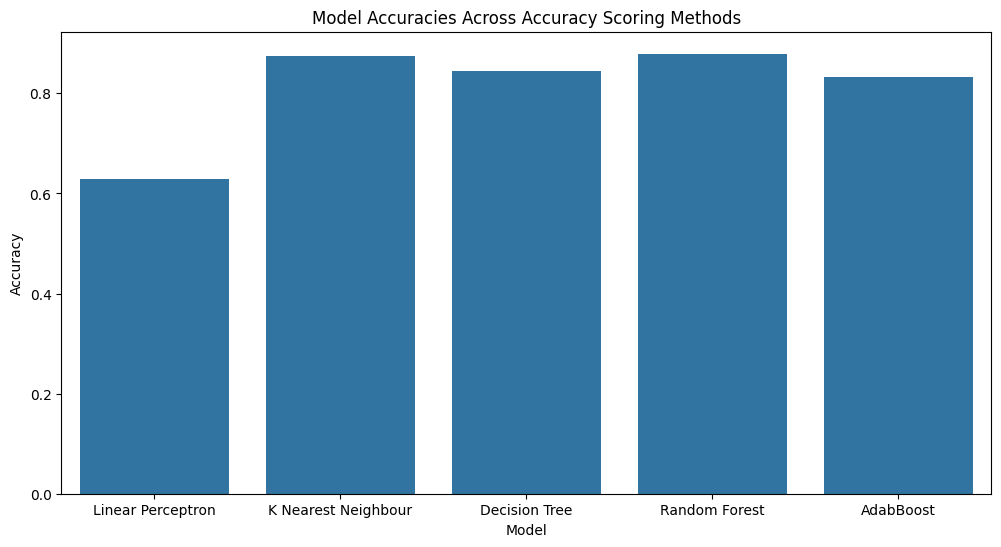

In [70]:
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x='model', y='accuracy')

# Labels and title
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracies Across Accuracy Scoring Methods")

# Show plot
plt.show()
